In [1]:
from util_fdp import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

ABC_TABLE = {
    (0.25, 1):(0.51, 100, 20), 
    (0.25, 5):(0.51, 100, 20), 
    (0.25, 'log'):(0.51, 100, 20), 
    (0.9, 1): (0.51, 100, 20),
    (0.9, 5): (0.568, 0, 1),
    (0.9, 'log'): (0.782, 25, 2),
}
DEFAULT_ABC = (0.51, 100, 20)
def get_abc(E_typ: str, E_cons, r: float,
            default=DEFAULT_ABC, table=ABC_TABLE):
    """
    根据 (E_typ, E_cons, r) 返回 (a, b, c)。
    - E_typ ∈ {"cons", "log"}
    - E_cons ∈ {1, 5}  （当 E_typ == "cons" 时才使用）
    - r ∈ {0.25, 0.9}
    未匹配到时返回 default。
    """
    if gene_process == 'hete':
        key = (r, "log") if E_typ.lower() == "log" else (r, E_cons)
        return table.get(key, default)
    else:
        return (0.51, 100, 20)

# ── 必要导入 ───────────────────────────────────────────────────
from util_fdp import run_federated_trajectory
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
np.random.seed(2020)
# ── 全局设置（一次写好，到处复用）────────────────────────────
mpl.rcParams.update({
    'font.size': 13, 'axes.titlesize': 16, 'axes.labelsize': 14,
    'legend.fontsize': 12, 'lines.linewidth': 2.4,
})
COLORS = {
    'global': '#0072B2',   # 深蓝
    'c0'    : '#009E73',   # 绿
    'c1'    : '#7E79D2',   # 橙
    'ci'    : '#D55E00',   # 淡紫
}

In [2]:
# ── 抽取 & 对齐曲线到固定长度 N ───────────────────────────────
# ── 抽取曲线 (保留各自横轴) ──────────────────────────────────
def get_curves(E_typ, E_cons, N,
               *, base_seed=2020, n_clients=10,
               gene_process='hete',taus=0.5, rs=[]):
    """
    返回:
      xs_g, gavg, lo, up, true_q,
      xs_c0, c0, xs_c1, c1
    其中 xs_* 均已排序，长度各自与对应 y 一一对应。
    """
    a, b, c = get_abc(E_typ, E_cons, r)             # 动态取 abc
    true_q, traj = run_federated_trajectory(
        dist_type='normal', taus=taus,
        client_rs=rs, n_clients=n_clients, T=N,
        E_typ=E_typ, E_cons=E_cons, gene_process=gene_process,
        mode='federated',
        T_mode='samples',
        base_seed=base_seed, a=a, b=b, c=c)

    # ── Global 曲线 ──
    g_hist  = traj['global']['global_q_avg']
    v_hist  = traj['global']['global_variance']
    xs_g    = np.array(sorted(g_hist))
    gavg    = np.array([g_hist[k] for k in xs_g])
    gvar    = np.array([v_hist[k] for k in xs_g])
    z       = 6.753 if E_typ == 'log' else 6.74735
    lo, up  = gavg - z * np.sqrt(gvar), gavg + z * np.sqrt(gvar)

    # ── Client 曲线（0 与 1） ──
    c0_hist = traj['local']['client_0']
    c1_hist = traj['local']['client_9']   # ← 若用 client_2 则改这里
    xs_c0   = np.array(sorted(c0_hist))
    xs_c1   = np.array(sorted(c1_hist))
    c0      = np.array([c0_hist[k] for k in xs_c0])
    c1      = np.array([c1_hist[k] for k in xs_c1])

    return xs_g, gavg, lo, up, true_q, xs_c0, c0, xs_c1, c1

In [3]:
# ── 抽取 & 对齐曲线到固定长度 N ───────────────────────────────
# ── 抽取曲线 (保留各自横轴) ──────────────────────────────────
def get_curves_global(N,
               *, base_seed=2020, n_clients=10,
               gene_process='hete',taus=0.5, rs=[]):
    """
    返回:
      xs_g, gavg, lo, up, true_q,
      xs_c0, c0, xs_c1, c1
    其中 xs_* 均已排序，长度各自与对应 y 一一对应。
    """
    a, b, c = 0.51, 100, 2
    true_q, traj = run_federated_trajectory(
        dist_type='normal', taus=taus,
        client_rs=rs, n_clients=n_clients, T=N,
        E_typ='cons', E_cons=1, gene_process=gene_process,
        mode='global',
        T_mode='samples',
        base_seed=base_seed, a=a, b=b, c=c)

    z       = 6.74735
    # client 0
    q0_hist = traj[0]['q_avg']
    v0_hist = traj[0]['variance']
    xs_c0   = np.array(sorted(q0_hist))
    c0      = np.array([q0_hist[k] for k in xs_c0])
    var0    = np.array([v0_hist[k] for k in xs_c0])
    lo0     = c0 - z * np.sqrt(var0)
    up0     = c0 + z * np.sqrt(var0)

    # client 9
    q9_hist = traj[9]['q_avg']
    v9_hist = traj[9]['variance']
    xs_c9   = np.array(sorted(q9_hist))
    c9      = np.array([q9_hist[k] for k in xs_c9])
    var9    = np.array([v9_hist[k] for k in xs_c9])
    lo9     = c9 - z * np.sqrt(var9)
    up9     = c9 + z * np.sqrt(var9)

    return xs_c0, c0, lo0, up0, xs_c9, c9, lo9, up9, true_q

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator

# ───────────────────────── 基础工具 ───────────────────────── #
def _safe_plot(ax, xs, ys, *args, **kwargs):
    """忽略全 NaN 或近似全 0 的曲线，防止多余水平线。"""
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    if np.all(np.isnan(ys)) or np.all(np.abs(ys) < 1e-12):
        return
    m = ~np.isnan(ys)
    ax.plot(xs[m], ys[m], *args, **kwargs)

def plot_panel(ax,
               xs_g, gavg, lo, up, true_q,
               xs_c0, c0, xs_c1, c1,
               lo0=None, up0=None, lo1=None, up1=None,
               *, scale=100, add_ylabel=False, add_legend=False,
               title=None, x_max=None, y_lims=None):
    """画一幅子图。"""
    # Global
    _safe_plot(ax, xs_g, gavg, color=COLORS['global'], label='Global')
    _safe_plot(ax, xs_g, lo,   '--', color=COLORS['ci'], lw=2, label='CI bounds')
    _safe_plot(ax, xs_g, up,   '--', color=COLORS['ci'], lw=2)
    # Client 0
    _safe_plot(ax, xs_c0, c0, '-.', color=COLORS['c0'], label='Client 0')
    if lo0 is not None and up0 is not None:
        _safe_plot(ax, xs_c0, lo0, '--', color=COLORS['c0'], alpha=0.4)
        _safe_plot(ax, xs_c0, up0, '--', color=COLORS['c0'], alpha=0.4)
    # Client 1/9
    _safe_plot(ax, xs_c1, c1, ':', color=COLORS['c1'], label='Client 9')
    if lo1 is not None and up1 is not None:
        _safe_plot(ax, xs_c1, lo1, '--', color=COLORS['c1'], alpha=0.4)
        _safe_plot(ax, xs_c1, up1, '--', color=COLORS['c1'], alpha=0.4)
    ax.axhline(true_q, ls='--', color='gray', lw=2, label=r'True $q$')

    # 轴刻度与范围
    ax.grid(axis='y', ls=':', alpha=0.7)
    if x_max is not None:
        ax.set_xlim(0, x_max)
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x/scale)}'))
    if y_lims is not None:
        ax.set_ylim(*y_lims)

    ax.set_xlabel(r'$(\times1000)$', fontsize=12)
    if add_ylabel:
        ax.set_ylabel('Quantile')
    if title:
        ax.set_title(title)
    if add_legend:
        ax.legend(frameon=False)

# ─────────────────── 数据准备封装 ─────────────────── #
def prepare_curves_and_titles(
        configs, *,
        N, seed, n_clients,
        taus, gene_process, rs,
        title_map=None,
        local_title=r'Only Local Updates'):
    """批量取曲线并追加 dummy local-only 曲线。"""
    curves_all = [
        get_curves(typ, econ, N=N, base_seed=seed,
                   n_clients=n_clients, taus=taus,
                   gene_process=gene_process, rs=rs)
        for typ, econ in configs
    ]

    # dummy 曲线
    new_curve = get_curves_global(N=N, base_seed=seed,
                                  n_clients=n_clients, taus=taus,
                                  gene_process=gene_process, rs=rs)
    xs_fake = new_curve[0]
    nan_curve = (
        xs_fake,
        np.full_like(xs_fake, np.nan),  # gavg
        np.full_like(xs_fake, np.nan),  # lo
        np.full_like(xs_fake, np.nan),  # up
        new_curve[-1],                  # true_q
        *new_curve[:4],                 # xs_c0, c0, lo0, up0
        *new_curve[4:8]                 # xs_c9, c9, lo9, up9
    )
    curves_all.append(nan_curve)

    # 标题
    if title_map is None:
        title_map = {
            ('cons', 1): r'$C=1$',
            ('cons', 5): r'$C=5$',
            ('log', 5):  r'$C=\log T$'
        }
    titles = [title_map.get(cfg, str(cfg)) for cfg in configs] + [local_title]
    return curves_all, titles

# ──────────────────── 绘图封装 ──────────────────── #
def plot_trace_grid(curves_all, titles,
                    *, x_max, y_common, y_last,
                    figsize_per_panel=(4, 4),
                    scale=100,
                    nbins_last=3,
                    out_path=None, dpi=250):
    """画网格子图，最后一幅用独立 y 轴。"""
    n_panels = len(curves_all)
    fig_w, fig_h = figsize_per_panel
    fig, axes = plt.subplots(1, n_panels,
                             figsize=(fig_w*n_panels, fig_h),
                             sharey=False)

    for i, (ax, curves, t) in enumerate(zip(axes, curves_all, titles)):
        is_first = (i == 0)
        is_last  = (i == n_panels-1)
        # ---- 调用 plot_panel ----
        if len(curves) == 9:          # 老格式
            plot_panel(ax, *curves,
                       add_ylabel=False,
                       add_legend=is_first,
                       title=t,
                       x_max=x_max,
                       y_lims=y_last if is_last else y_common,
                       scale=scale)
        else:                         # 新格式
            plot_panel(ax, *curves,
                       add_ylabel=False,
                       add_legend=is_first,
                       title=t,
                       x_max=x_max,
                       y_lims=y_last if is_last else y_common,
                       scale=scale)
        # ---- 刻度处理 ----
        if is_first or is_last:
            ax.tick_params(labelleft=True)
        else:
            ax.tick_params(labelleft=False)
        if is_last:
            ax.yaxis.set_major_locator(MaxNLocator(nbins=nbins_last))

    fig.tight_layout(pad=0.3)
    fig.subplots_adjust(wspace=0.07)
    if out_path:
        fig.savefig(out_path, dpi=dpi)
    return fig, axes

In [ ]:
z_score = 6.753 if E == 'log' else 6.74735
1/3 6.339
1/2 5.851
2/3 4.993

/opt/anaconda3/envs/ray/lib/python3.12/site-packages/numpy/_core/numeric.py:442: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


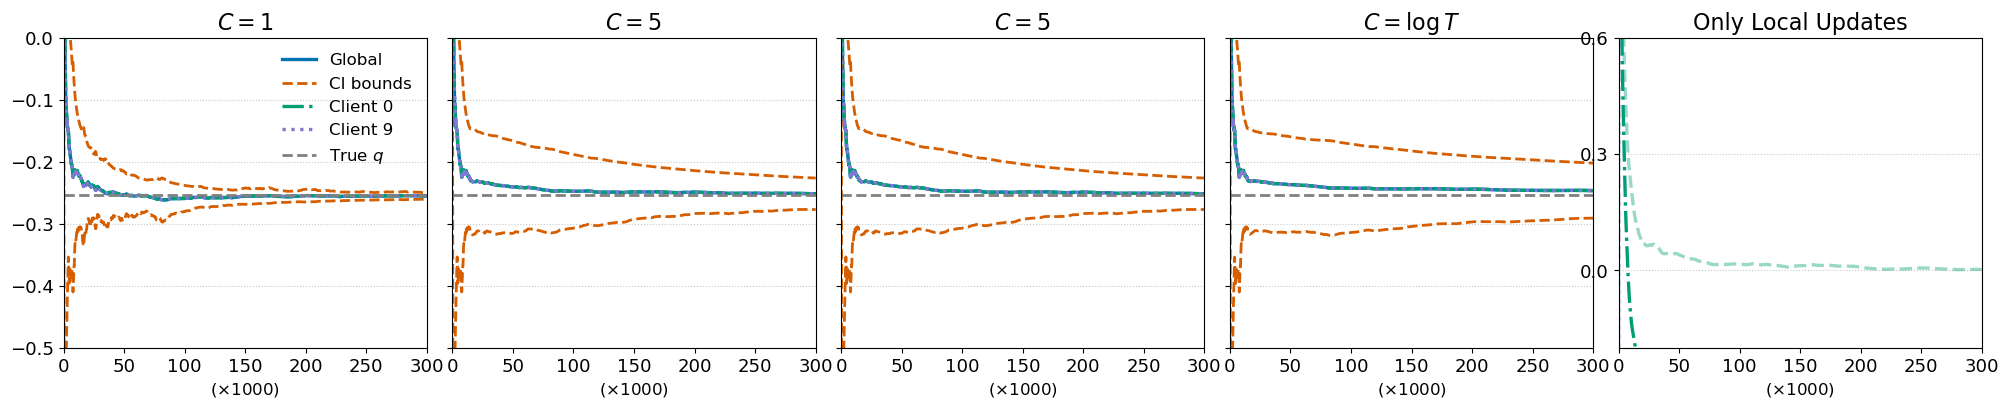

In [6]:
# ─────────────────────── 主脚本 ─────────────────────── #

# 参数
taus         = np.linspace(0.3, 0.5, 10).tolist()
gene_process = 'homo'
r            = 0.9
rs           = [r]*10
N            = 30_000
seed         = 1
configs      = [('cons', 1), ('cons', 5),('cons', 5), ('log', 5)]

# 曲线与标题
curves_all, titles = prepare_curves_and_titles(
    configs,
    N=N, seed=seed, n_clients=10,
    taus=taus, gene_process=gene_process, rs=rs
)

# 绘图
plot_trace_grid(
    curves_all, titles,
    x_max=30_000,
    y_common=(-0.5, 0),
    y_last=(-0.2, 0.6),
    out_path=f'output/trace_{gene_process}_r_{r}_with_client_only.pdf'
)
plt.show()

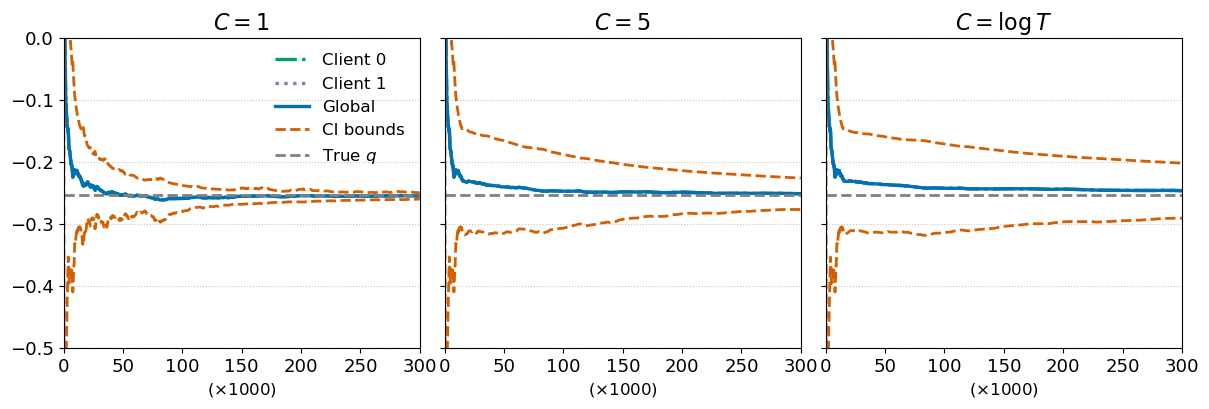

In [12]:

# ── 绘图阶段 ────────────────────────────────────────────────
configs = [('cons', 1),('cons', 5),('log', 5)]
fig, axes = plt.subplots(1, len(configs), figsize=(4*len(configs), 4),
                         sharey=True)
titles = [r'$C=1$', r'$C=5$', r'$C=\log T$']   # 想写中文或别的都行

for i, (ax, curves, t) in enumerate(zip(axes, curves_all, titles)):
    plot_panel(ax, *curves,
               add_ylabel=False,          # 关闭 y 轴标题
               add_legend=(i == 0),       # 只在第一张放图例
               title=t,                # 关闭子图标题
               x_max=30000,
              y_lims=(-0.5,0))      # 固定横轴上限

    # 去掉 x 轴标签
    ax.set_xlabel(r'$(\times 1000)$', fontsize=12)
    # ax.set_xlabel('')                     # 若不想留空白，可注释掉这行
    # 去掉 y 轴标签（已经通过 add_ylabel=False 实现）

# 可选：如果想让最外层整体去掉两侧多余空白
fig.tight_layout(pad=0.3)          # 图与图框之间留 0.3 英寸
fig.subplots_adjust(wspace=0.07)   # ② 调整列间距；数值越小越紧
plt.savefig(f'output/trace_{gene_process}_r_{r}.pdf',dpi=250)
plt.show()

In [7]:
## 
tau = 0.3
gene_process = 'homo'
r = 0.9
rs = [r]*10
configs = [('cons', 1)]
N       = 20_000
seed    = 1

In [ ]:
configs = [('cons', 1)]
curves_1 = [
    get_curves(typ, econ, N=30000, base_seed=seed,
               n_clients=10,tau=tau,
               gene_process=gene_process, rs=rs)
    for typ, econ in configs]

configs = [('cons', 5), ('cons', 10), ('log', 5)]
curves_all_1 = [
    get_curves(typ, econ, N=N, base_seed=seed,
               n_clients=10,tau=tau,
               gene_process=gene_process, rs=rs)
    for typ, econ in configs]

curves_all = curves_1 + curves_all_1


# ── 绘图阶段 ────────────────────────────────────────────────
configs = [('cons', 1),('cons', 5), ('cons', 10), ('log', 5)]
fig, axes = plt.subplots(1, len(configs), figsize=(4*len(configs), 4),
                         sharey=True)

for i, (ax, curves) in enumerate(zip(axes, curves_all)):
    plot_panel(ax, *curves,
               add_ylabel=False,          # 关闭 y 轴标题
               add_legend=(i == 0),       # 只在第一张放图例
               title=None,                # 关闭子图标题
               x_max=30000, y_lims=(-0.8,-0.2))      # 固定横轴上限

    # 去掉 x 轴标签
    ax.set_xlabel(r'$(\times 1000)$', fontsize=12)
    # ax.set_xlabel('')                     # 若不想留空白，可注释掉这行
    # 去掉 y 轴标签（已经通过 add_ylabel=False 实现）

# 可选：如果想让最外层整体去掉两侧多余空白
fig.tight_layout(pad=0.3)          # 图与图框之间留 0.3 英寸
fig.subplots_adjust(wspace=0.15)   # ② 调整列间距；数值越小越紧
plt.savefig(f'trace_tau_{tau}_{gene_process}_r_{r}.pdf',dpi=250)
plt.show()

In [24]:
## 
tau = 0.8
gene_process = 'homo'
r = 0.9
rs = [r]*10
configs = [('cons', 1)]
N       = 20_000
seed    = 2

In [25]:
configs = [('cons', 1)]
curves_1 = [
    get_curves(typ, econ, N=20000, base_seed=seed,
               n_clients=10,tau=tau,
               gene_process=gene_process, rs=rs)
    for typ, econ in configs]

In [26]:
configs = [('cons', 5), ('cons', 10), ('log', 5)]
curves_all_1 = [
    get_curves(typ, econ, N=N, base_seed=seed,
               n_clients=10,tau=tau,
               gene_process=gene_process, rs=rs)
    for typ, econ in configs]

curves_all = curves_1 + curves_all_1

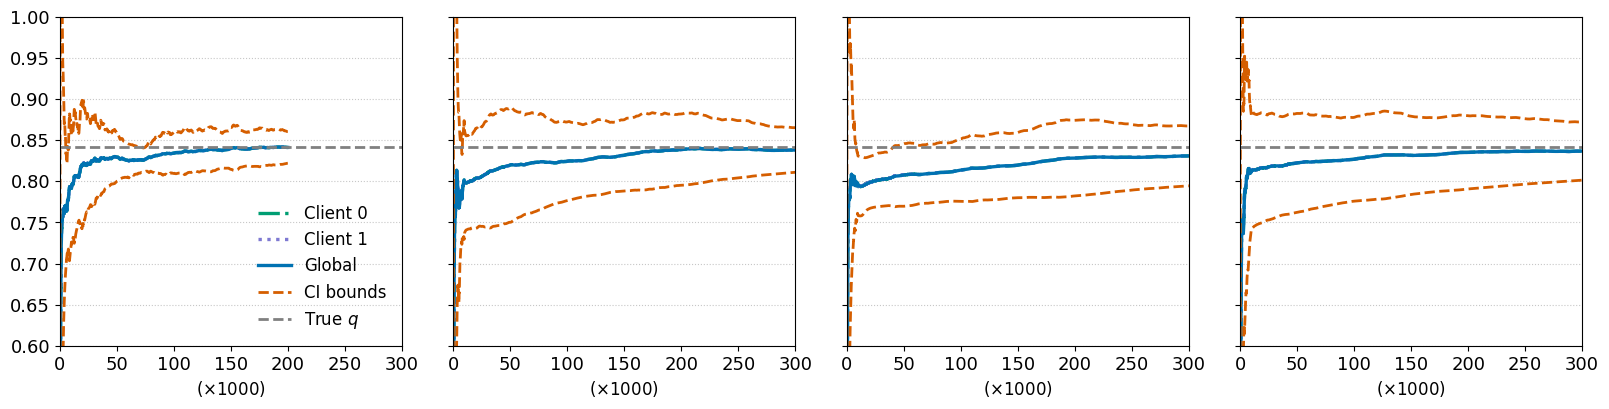

In [27]:
# ── 绘图阶段 ────────────────────────────────────────────────
configs = [('cons', 1),('cons', 5), ('cons', 10), ('log', 5)]
fig, axes = plt.subplots(1, len(configs), figsize=(4*len(configs), 4),
                         sharey=True)

for i, (ax, curves) in enumerate(zip(axes, curves_all)):
    plot_panel(ax, *curves,
               add_ylabel=False,          # 关闭 y 轴标题
               add_legend=(i == 0),       # 只在第一张放图例
               title=None,                # 关闭子图标题
               x_max=30000, y_lims=(0.6,1.0))      # 固定横轴上限

    # 去掉 x 轴标签
    ax.set_xlabel(r'$(\times 1000)$', fontsize=12)
    # ax.set_xlabel('')                     # 若不想留空白，可注释掉这行
    # 去掉 y 轴标签（已经通过 add_ylabel=False 实现）

# 可选：如果想让最外层整体去掉两侧多余空白
fig.tight_layout(pad=0.3)          # 图与图框之间留 0.3 英寸
fig.subplots_adjust(wspace=0.15)   # ② 调整列间距；数值越小越紧
plt.savefig(f'trace_tau_{tau}_{gene_process}_r_{r}.pdf',dpi=250)
plt.show()

In [ ]:
## 
tau = 0.5
gene_process = 'homo'
rs = np.linspace(0.25, 0.9, 10).tolist()
configs = [('cons', 1)]
N       = 20_000
# seed    = 3
seed    = 10

configs = [('cons', 1)]
curves_1 = [
    get_curves(typ, econ, N=30000, base_seed=seed,
               n_clients=10,tau=tau,
               gene_process=gene_process, rs=rs)
    for typ, econ in configs]

configs = [('cons', 5), ('cons', 10), ('log', 5)]
curves_all_1 = [
    get_curves(typ, econ, N=N, base_seed=seed,
               n_clients=10,tau=tau,
               gene_process=gene_process, rs=rs)
    for typ, econ in configs]

curves_all = curves_1 + curves_all_1

# ── 绘图阶段 ────────────────────────────────────────────────
configs = [('cons', 1),('cons', 5), ('cons', 10), ('log', 5)]
fig, axes = plt.subplots(1, len(configs), figsize=(4*len(configs), 4),
                         sharey=True)

for i, (ax, curves) in enumerate(zip(axes, curves_all)):
    plot_panel(ax, *curves,
               add_ylabel=False,          # 关闭 y 轴标题
               add_legend=(i == 0),       # 只在第一张放图例
               title=None,                # 关闭子图标题
               x_max=30000, y_lims=(-0.15,0.15))      # 固定横轴上限

    # 去掉 x 轴标签
    ax.set_xlabel(r'$(\times 1000)$', fontsize=12)
    # ax.set_xlabel('')                     # 若不想留空白，可注释掉这行
    # 去掉 y 轴标签（已经通过 add_ylabel=False 实现）

# 可选：如果想让最外层整体去掉两侧多余空白
fig.tight_layout(pad=0.3)          # 图与图框之间留 0.3 英寸
fig.subplots_adjust(wspace=0.15)   # ② 调整列间距；数值越小越紧
plt.savefig(f'trace_tau_{tau}_{gene_process}_r_hete.pdf',dpi=250)
plt.show()

In [ ]:
## 
tau = 0.3
gene_process = 'homo'
rs = np.linspace(0.25, 0.9, 10).tolist()
configs = [('cons', 1)]
N       = 20_000
# seed    = 3
seed    = 10

configs = [('cons', 1)]
curves_1 = [
    get_curves(typ, econ, N=30000, base_seed=seed,
               n_clients=10,tau=tau,
               gene_process=gene_process, rs=rs)
    for typ, econ in configs]

configs = [('cons', 5), ('cons', 10), ('log', 5)]
curves_all_1 = [
    get_curves(typ, econ, N=N, base_seed=seed,
               n_clients=10,tau=tau,
               gene_process=gene_process, rs=rs)
    for typ, econ in configs]

curves_all = curves_1 + curves_all_1

# ── 绘图阶段 ────────────────────────────────────────────────
configs = [('cons', 1),('cons', 5), ('cons', 10), ('log', 5)]
fig, axes = plt.subplots(1, len(configs), figsize=(4*len(configs), 4),
                         sharey=True)

for i, (ax, curves) in enumerate(zip(axes, curves_all)):
    plot_panel(ax, *curves,
               add_ylabel=False,          # 关闭 y 轴标题
               add_legend=(i == 0),       # 只在第一张放图例
               title=None,                # 关闭子图标题
               x_max=30000, y_lims=(-0.8,-0.2))      # 固定横轴上限

    # 去掉 x 轴标签
    ax.set_xlabel(r'$(\times 1000)$', fontsize=12)
    # ax.set_xlabel('')                     # 若不想留空白，可注释掉这行
    # 去掉 y 轴标签（已经通过 add_ylabel=False 实现）

# 可选：如果想让最外层整体去掉两侧多余空白
fig.tight_layout(pad=0.3)          # 图与图框之间留 0.3 英寸
fig.subplots_adjust(wspace=0.15)   # ② 调整列间距；数值越小越紧
plt.savefig(f'trace_tau_{tau}_{gene_process}_r_hete.pdf',dpi=250)
plt.show()

In [93]:
## 
tau = 0.8
gene_process = 'homo'
rs = np.linspace(0.25, 0.9, 10).tolist()
configs = [('cons', 1)]
N       = 20_000
# seed    = 3
seed    = 10

configs = [('cons', 1)]
curves_1 = [
    get_curves(typ, econ, N=30000, base_seed=seed,
               n_clients=10,tau=tau,
               gene_process=gene_process, rs=rs)
    for typ, econ in configs]

configs = [('cons', 5), ('cons', 10), ('log', 5)]
curves_all_1 = [
    get_curves(typ, econ, N=N, base_seed=seed,
               n_clients=10,tau=tau,
               gene_process=gene_process, rs=rs)
    for typ, econ in configs]

curves_all = curves_1 + curves_all_1

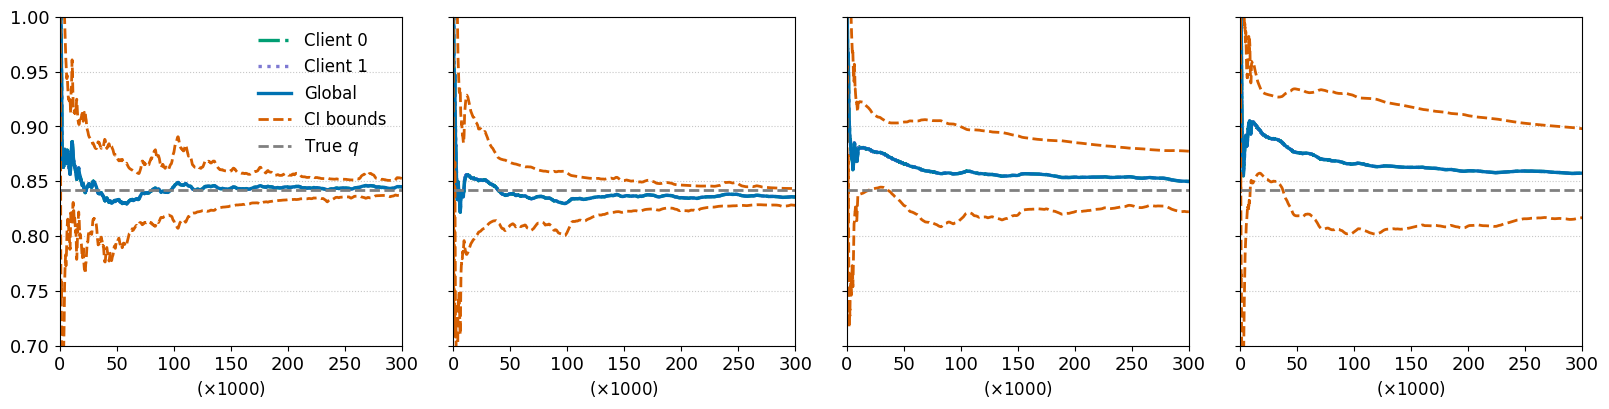

In [96]:
# ── 绘图阶段 ────────────────────────────────────────────────
configs = [('cons', 1),('cons', 5), ('cons', 10), ('log', 5)]
fig, axes = plt.subplots(1, len(configs), figsize=(4*len(configs), 4),
                         sharey=True)

for i, (ax, curves) in enumerate(zip(axes, curves_all)):
    plot_panel(ax, *curves,
               add_ylabel=False,          # 关闭 y 轴标题
               add_legend=(i == 0),       # 只在第一张放图例
               title=None,                # 关闭子图标题
               x_max=30000,y_lims=(0.7,1.0))      # 固定横轴上限

    # 去掉 x 轴标签
    ax.set_xlabel(r'$(\times 1000)$', fontsize=12)
    # ax.set_xlabel('')                     # 若不想留空白，可注释掉这行
    # 去掉 y 轴标签（已经通过 add_ylabel=False 实现）

# 可选：如果想让最外层整体去掉两侧多余空白
fig.tight_layout(pad=0.3)          # 图与图框之间留 0.3 英寸
fig.subplots_adjust(wspace=0.15)   # ② 调整列间距；数值越小越紧
plt.savefig(f'trace_tau_{tau}_{gene_process}_r_hete.pdf',dpi=250)
plt.show()